In [13]:
import pandas as pd
import numpy as np
import os
from sklearn.utils import shuffle

In [15]:
FTRAIN = '~/Downloads/training.csv'
FTEST = '~/Downloads/test.csv'

def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [1]:
import tensorflow as tf

In [29]:
def fc(x, name, in_channels, out_channels, initializer=None, relu=True):
    with tf.variable_scope(name) as scope:
        weights = tf.get_variable(name='weights',
                                  shape=[in_channels, out_channels],
                                  initializer=initializer)
        biases = tf.get_variable(name='biases',
                                 shape=[out_channels],
                                 initializer=initializer)
        act = tf.nn.xw_plus_b(x, weights, biases, name=scope.name)
    if relu:
        act = tf.nn.relu(act)
    return act        

In [4]:
def inference(x):
    hidden = fc(x, 'hidden', 96 * 96, 100)
    output = fc(hidden, 'output', 100, 30, relu=False)
    return output

In [5]:
def loss(scores, labels):
    loss = tf.losses.mean_squared_error(labels,
                                        scores)
    return loss

In [6]:
learning_rate = 0.01
momentum = 0.9

def train(loss):
    lr_var_opt = tf.train.MomentumOptimizer(learning_rate, momentum)
    lr_var_grads = lr_var_opt.compute_gradients(loss)
    apply_gradient_op = lr_var_opt.apply_gradients(lr_var_grads)
    return apply_gradient_op

In [37]:
X.shape

(2140, 9216)

In [54]:
from datetime import datetime
import time 

NUM_EPOCHS = 400
NUM_STEPS = 17
BATCH = 128

def train_():
    with tf.Graph().as_default():
        x = tf.placeholder(dtype='float32',
                           shape=[None, 96 * 96],
                           name='x')
        labels = tf.placeholder(dtype='float32',
                                shape=[None, 30],
                                name='labels')
        dataset = tf.contrib.data.Dataset.from_tensor_slices((x, labels)).batch(BATCH)
        iterator = dataset.make_initializable_iterator()

        next_x, next_y = iterator.get_next()
        scores = inference(next_x)
        total_loss = loss(scores, next_y)
        train_op = train(total_loss)

        saver = tf.train.Saver()

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(NUM_EPOCHS):
                sess.run(iterator.initializer, feed_dict={x: X, labels: y})
                for j in range(0, NUM_STEPS):
                    loss_, _ = sess.run([total_loss, train_op])
                print(loss_)
                dest_directory = os.path.join('Desktop/face_data', 'face_train')
                checkpoint_name = os.path.join(dest_directory,
                                           'model_epoch'+str(i)+'.ckpt')
                save_path = saver.save(sess, checkpoint_name)
                print("{} Model checkpoint saved at {}".format(datetime.now(),
                                                           checkpoint_name))

In [55]:
dest_directory = os.path.join('Desktop/face_data', 'face_train')
if tf.gfile.Exists(dest_directory):
    tf.gfile.DeleteRecursively(dest_directory)
tf.gfile.MakeDirs(dest_directory)
train_()

0.0377428
2018-06-23 15:59:56.528793 Model checkpoint saved at Desktop/face_data/face_train/model_epoch0.ckpt
0.0195375
2018-06-23 15:59:57.039596 Model checkpoint saved at Desktop/face_data/face_train/model_epoch1.ckpt
0.0146319
2018-06-23 15:59:57.538618 Model checkpoint saved at Desktop/face_data/face_train/model_epoch2.ckpt
0.0131569
2018-06-23 15:59:58.041406 Model checkpoint saved at Desktop/face_data/face_train/model_epoch3.ckpt
0.0121231
2018-06-23 15:59:58.542059 Model checkpoint saved at Desktop/face_data/face_train/model_epoch4.ckpt
0.0114628
2018-06-23 15:59:59.047135 Model checkpoint saved at Desktop/face_data/face_train/model_epoch5.ckpt
0.010929
2018-06-23 15:59:59.554693 Model checkpoint saved at Desktop/face_data/face_train/model_epoch6.ckpt
0.0104649
2018-06-23 16:00:00.067266 Model checkpoint saved at Desktop/face_data/face_train/model_epoch7.ckpt
0.0100654
2018-06-23 16:00:00.585904 Model checkpoint saved at Desktop/face_data/face_train/model_epoch8.ckpt
0.00972218


0.00480036
2018-06-23 16:00:36.778187 Model checkpoint saved at Desktop/face_data/face_train/model_epoch74.ckpt
0.00477002
2018-06-23 16:00:37.290528 Model checkpoint saved at Desktop/face_data/face_train/model_epoch75.ckpt
0.00473959
2018-06-23 16:00:37.851599 Model checkpoint saved at Desktop/face_data/face_train/model_epoch76.ckpt
0.00471004
2018-06-23 16:00:38.354288 Model checkpoint saved at Desktop/face_data/face_train/model_epoch77.ckpt
0.00468151
2018-06-23 16:00:38.852530 Model checkpoint saved at Desktop/face_data/face_train/model_epoch78.ckpt
0.00465254
2018-06-23 16:00:39.352540 Model checkpoint saved at Desktop/face_data/face_train/model_epoch79.ckpt
0.00462393
2018-06-23 16:00:39.855873 Model checkpoint saved at Desktop/face_data/face_train/model_epoch80.ckpt
0.0045959
2018-06-23 16:00:40.439180 Model checkpoint saved at Desktop/face_data/face_train/model_epoch81.ckpt
0.00456931
2018-06-23 16:00:41.008811 Model checkpoint saved at Desktop/face_data/face_train/model_epoch8

0.00341907
2018-06-23 16:01:17.494055 Model checkpoint saved at Desktop/face_data/face_train/model_epoch147.ckpt
0.00340962
2018-06-23 16:01:18.056209 Model checkpoint saved at Desktop/face_data/face_train/model_epoch148.ckpt
0.00340047
2018-06-23 16:01:18.559596 Model checkpoint saved at Desktop/face_data/face_train/model_epoch149.ckpt
0.00339398
2018-06-23 16:01:19.115736 Model checkpoint saved at Desktop/face_data/face_train/model_epoch150.ckpt
0.00338919
2018-06-23 16:01:19.614109 Model checkpoint saved at Desktop/face_data/face_train/model_epoch151.ckpt
0.00338078
2018-06-23 16:01:20.107842 Model checkpoint saved at Desktop/face_data/face_train/model_epoch152.ckpt
0.00337486
2018-06-23 16:01:20.656260 Model checkpoint saved at Desktop/face_data/face_train/model_epoch153.ckpt
0.00337043
2018-06-23 16:01:21.220714 Model checkpoint saved at Desktop/face_data/face_train/model_epoch154.ckpt
0.0033638
2018-06-23 16:01:21.773582 Model checkpoint saved at Desktop/face_data/face_train/mode

0.00270586
2018-06-23 16:01:59.452550 Model checkpoint saved at Desktop/face_data/face_train/model_epoch220.ckpt
0.00269541
2018-06-23 16:01:59.958218 Model checkpoint saved at Desktop/face_data/face_train/model_epoch221.ckpt
0.0026868
2018-06-23 16:02:00.461132 Model checkpoint saved at Desktop/face_data/face_train/model_epoch222.ckpt
0.00267703
2018-06-23 16:02:00.951833 Model checkpoint saved at Desktop/face_data/face_train/model_epoch223.ckpt
0.00266817
2018-06-23 16:02:01.441628 Model checkpoint saved at Desktop/face_data/face_train/model_epoch224.ckpt
0.00265907
2018-06-23 16:02:01.933530 Model checkpoint saved at Desktop/face_data/face_train/model_epoch225.ckpt
0.00265141
2018-06-23 16:02:02.432210 Model checkpoint saved at Desktop/face_data/face_train/model_epoch226.ckpt
0.00264369
2018-06-23 16:02:02.934498 Model checkpoint saved at Desktop/face_data/face_train/model_epoch227.ckpt
0.0026361
2018-06-23 16:02:03.432871 Model checkpoint saved at Desktop/face_data/face_train/model

0.0022866
2018-06-23 16:02:37.845781 Model checkpoint saved at Desktop/face_data/face_train/model_epoch293.ckpt
0.0022826
2018-06-23 16:02:38.429855 Model checkpoint saved at Desktop/face_data/face_train/model_epoch294.ckpt
0.00227868
2018-06-23 16:02:38.929496 Model checkpoint saved at Desktop/face_data/face_train/model_epoch295.ckpt
0.00227472
2018-06-23 16:02:39.612805 Model checkpoint saved at Desktop/face_data/face_train/model_epoch296.ckpt
0.00227085
2018-06-23 16:02:40.184318 Model checkpoint saved at Desktop/face_data/face_train/model_epoch297.ckpt
0.00226632
2018-06-23 16:02:40.732067 Model checkpoint saved at Desktop/face_data/face_train/model_epoch298.ckpt
0.00226288
2018-06-23 16:02:41.391189 Model checkpoint saved at Desktop/face_data/face_train/model_epoch299.ckpt
0.00225903
2018-06-23 16:02:41.959748 Model checkpoint saved at Desktop/face_data/face_train/model_epoch300.ckpt
0.00225519
2018-06-23 16:02:42.531924 Model checkpoint saved at Desktop/face_data/face_train/model

0.00203296
2018-06-23 16:03:17.086359 Model checkpoint saved at Desktop/face_data/face_train/model_epoch366.ckpt
0.0020307
2018-06-23 16:03:17.616071 Model checkpoint saved at Desktop/face_data/face_train/model_epoch367.ckpt
0.00202727
2018-06-23 16:03:18.122313 Model checkpoint saved at Desktop/face_data/face_train/model_epoch368.ckpt
0.00202442
2018-06-23 16:03:18.622004 Model checkpoint saved at Desktop/face_data/face_train/model_epoch369.ckpt
0.00202136
2018-06-23 16:03:19.128277 Model checkpoint saved at Desktop/face_data/face_train/model_epoch370.ckpt
0.00201775
2018-06-23 16:03:19.637587 Model checkpoint saved at Desktop/face_data/face_train/model_epoch371.ckpt
0.00201456
2018-06-23 16:03:20.155832 Model checkpoint saved at Desktop/face_data/face_train/model_epoch372.ckpt
0.00201169
2018-06-23 16:03:20.667920 Model checkpoint saved at Desktop/face_data/face_train/model_epoch373.ckpt
0.00200934
2018-06-23 16:03:21.176254 Model checkpoint saved at Desktop/face_data/face_train/mode

In [57]:
X_test, _ = load(test=True)
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X_test.shape, X_test.min(), X_test.max()))

ImageId    1783
Image      1783
dtype: int64
X.shape == (1783, 9216); X.min == 0.000; X.max == 1.000


In [73]:
EVAL_NUM_STEPS = 14
answer = np.zeros([1783, 30])

def eval_():
    with tf.Graph().as_default():
        x = tf.placeholder(dtype='float32',
                           shape=[None, 96 * 96],
                           name='x')
        dataset = tf.contrib.data.Dataset.from_tensor_slices(x).batch(BATCH)
        iterator = dataset.make_initializable_iterator()

        next_x = iterator.get_next()
        scores = inference(next_x)
        
        saver = tf.train.Saver()

        with tf.Session() as sess:
            sess.run(iterator.initializer, feed_dict={x: X_test})
            ckpt = tf.train.get_checkpoint_state('Desktop/face_data/face_train')
            if ckpt and ckpt.model_checkpoint_path:
                # Restores from checkpoint
                saver.restore(sess, ckpt.model_checkpoint_path)
            else:
                print('No checkpoint file found')
                return    
            count = 0
            for j in range(0, EVAL_NUM_STEPS):
                ans = sess.run(scores)
                for i in range(0, ans.shape[0]):
                    answer[count] = ans[i, :]
                    count = count + 1
            print(count)

In [74]:
eval_()

INFO:tensorflow:Restoring parameters from Desktop/face_data/face_train/model_epoch399.ckpt


INFO:tensorflow:Restoring parameters from Desktop/face_data/face_train/model_epoch399.ckpt


1783


In [76]:
answer[1782, :]

array([ 0.34266454, -0.19480854, -0.34234387, -0.20044652,  0.23177713,
       -0.19203773,  0.52397913, -0.20087776, -0.22145718, -0.2337434 ,
       -0.48479342, -0.21374954,  0.19409248, -0.37329829,  0.61825746,
       -0.34438282, -0.17403042, -0.38964564, -0.61111212, -0.35868752,
       -0.01700468,  0.18900745,  0.28991807,  0.53935122, -0.30781367,
        0.54313451, -0.05001522,  0.4258877 , -0.0093363 ,  0.68588436])

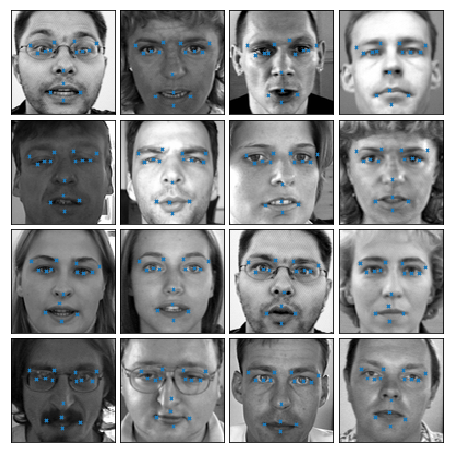

In [78]:
import matplotlib.pyplot as pyplot

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], answer[i], ax)

pyplot.show()